# Tutorial: Particle Filtering in Gen

Sequential Monte Carlo (SMC) methods such as particle filtering iteratively solve a *sequence of inference problems* using techniques based on importance sampling and in some cases MCMC. The solution to each problem in the sequence is represented as a collection of samples or *particles*. The particles for each problem are based on extending or adjusting the particles for the previous problem in the sequence.

The sequence of inference problems that are solved often arise naturally from observations that arrive incrementally, as in particle filtering. The problems can also be constructed instrumentally to facilitate inference, as in annealed importance sampling [3]. This tutorial shows how to use Gen to implement a particle filter for a tracking problem that uses "rejuvenation" MCMC moves. Specifically, we will address the "bearings only tracking" problem described in [4].

[1] Doucet, Arnaud, Nando De Freitas, and Neil Gordon. "An introduction to sequential Monte Carlo methods." Sequential Monte Carlo methods in practice. Springer, New York, NY, 2001. 3-14.

[2] Del Moral, Pierre, Arnaud Doucet, and Ajay Jasra. "Sequential monte carlo samplers." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 68.3 (2006): 411-436.

[3] Neal, Radford M. "Annealed importance sampling." Statistics and computing 11.2 (2001): 125-139.

[4] Gilks, Walter R., and Carlo Berzuini. "Following a moving target—Monte Carlo inference for dynamic Bayesian models." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 63.1 (2001): 127-146. [PDF](http://www.mathcs.emory.edu/~whalen/Papers/BNs/MonteCarlo-DBNs.pdf)

## Outline

**Section 1**: [Implementing the generative model](#basic-model)

**Section 2**: [Implementing a basic particle filter](#basic-pf)

**Section 3**: [Adding rejuvenation moves](#rejuv)

**Section 4**: [Using the unfold combinator to improve performance](#unfold)

In [2]:
using Gen
using PyPlot

## 1. Implementing the generative model <a name="basic-model"></a>

We will implement a generative model for the movement of a point in the x-y plane and bearing measurements of the location of this point relative to the origin over time.

We assume that we know the approximate initial position and velocity of the point. We assume the point's x- and y- velocity are subject to random perturbations drawn from some normal distribution with a known variance. Each bearing measurement consists of the angle of the point being tracked relative to the positive x-axis.

We write the generative model as a generative function below. The function first samples the initial state of the point from a prior distribution, and then generates `T` successive states in a `for` loop. The argument to the model is the number of states not including the initial state.

In [3]:
bearing(x, y) = atan(y, x)

@gen function model(T::Int)
    
    measurement_noise = 0.005
    velocity_var = (1.0/1e6)

    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)

    # prior on initial x-coordinate
    x = @trace(normal(0.01, 0.01), :x0)
       
    # prior on initial y-coordinate
    y = @trace(normal(0.95, 0.01), :y0)
    
    # prior on x-component of initial velocity
    vx = @trace(normal(0.002, 0.01), :vx0)
    
    # prior on y-component of initial velocity
    vy = @trace(normal(-0.013, 0.01), :vy0)
    
    # initial bearing measurement
    @trace(normal(bearing(x, y), measurement_noise), :z0)

    # record position
    xs[1] = x
    ys[1] = y
    
    # generate successive states and measurements
    for t=1:T
        
        # update the state of the point
        vx = @trace(normal(vx, sqrt(velocity_var)), (:vx, t))
        vy = @trace(normal(vy, sqrt(velocity_var)), (:vy, t))
        x += vx
        y += vy
        
        # bearing measurement
        @trace(normal(bearing(x, y), measurement_noise), (:z, t))

        # record position
        xs[t+1] = x
        ys[t+1] = y
    end
    
    # return the sequence of positions
    return (xs, ys)
end;

We generate a data set of positions, and observed bearings, by sampling from this model, with `T=50`:

In [4]:
import Random
Random.seed!(4)

# generate trace with specific initial conditions
T = 50
constraints = Gen.choicemap((:x0, 0.01), (:y0, 0.95), (:vx0, 0.002), (:vy0, -0.013))
(trace, _) = Gen.generate(model, (T,), constraints)

# extract the observed data (zs) from the trace
choices = Gen.get_choices(trace)
zs = Vector{Float64}(undef, T+1)
zs[1] = choices[:z0]
for t=1:T
    zs[t+1] = choices[(:z, t)]
end

We next write a visualization for traces of this model below. It shows the positions and dots and the observed bearings as lines from the origin:

In [5]:
function render(trace; show_data=true, max_T=get_args(trace)[1])
    (T,) = Gen.get_args(trace)
    choices = Gen.get_choices(trace)
    (xs, ys) = Gen.get_retval(trace)
    zs = Vector{Float64}(undef, T+1)
    zs[1] = choices[:z0]
    for t=1:T
        zs[t+1] = choices[(:z, t)]
    end
    scatter(xs[1:max_T+1], ys[1:max_T+1], s=5)
    if show_data
        for z in zs[1:max_T+1]
            dx = cos(z) * 0.5
            dy = sin(z) * 0.5
            plot([0., dx], [0., dy], color="red", alpha=0.3)
        end
    end
end;

We visualize the synthetic trace below:

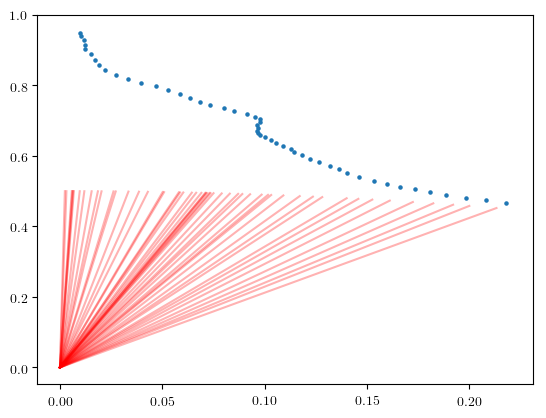

In [6]:
render(trace)

## 2. Implementing a basic particle filter <a name="basic-pf"></a>

In Gen, a **particle is represented as a trace** and the particle filter state contains a weighted collection of traces. Below we define an inference program that runs a particle filter on an observed data set of bearings (`zs`). We use `num_particles` particles internally, and then we return a sample of `num_samples` traces from the weighted collection that the particle filter produces.

Gen provides methods for initializing and updating the state of a particle filter, documented in [Particle Filtering](https://probcomp.github.io/Gen/dev/ref/inference/#Particle-Filtering-1).

- `Gen.initialize_particle_filter`

- `Gen.particle_filter_step!`

Both of these methods can used either with the default proposal or a custom proposal. In this tutorial, we will use the default proposal. There is also a method that resamples particles based on their weights, which serves to redistribute the particles to more promising parts of the latent space.

- `Gen.maybe_resample!`

Gen also provides a method for sampling a collection of unweighted traces from the current weighted collection in the particle filter state:

- `Gen.sample_unweighted_traces`

In [7]:
function particle_filter(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    
    # construct initial observations
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)
    
    # steps
    for t=1:length(zs)-1
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

The initial state is obtained by providing the following to `initialize_particle_filter`:

- The generative function for the generative model (`model`)

- The initial arguments to the generative function.

- The initial observations, expressed as a map from choice address to values (`init_obs`).

- The number of particles.

At each step, we resample from the collection of traces (`maybe_resample!`) and then we introduce one additional bearing measurement by calling `particle_filter_step!` on the state. We pass the following arguments to `particle_filter_step!`:

- The state (it will be mutated)

- The new arguments to the generative function for this step. In our case, this is the number of measurements beyond the first measurement.

- The [argdiff](https://probcomp.github.io/Gen/dev/ref/gfi/#Argdiffs-1) value, which provides detailed information about the change to the arguments between the previous step and this step. We will revisit this value later. For now, we indicat ethat we do not know how the `T::Int` argument will change with each step.

- The new observations associated with the new step. In our case, this just contains the latest measurement.


We run this particle filter with 5000 particles, and return a sample of 100 particles. This will take 30-60 seconds. We will see one way of speeding up the particle filter in a later section.

In [ ]:
@time pf_traces = particle_filter(5000, zs, 200);

To render these traces, we first define a function that overlays many renderings:

In [8]:
function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;

We then render the traces from the particle filter:

In [ ]:
overlay(render, pf_traces, same_data=true)

Notice that as during the period of denser bearing measurements, the trajectories tend to turn so that the heading is more parallel to the bearing vector. An alternative explanation is that the point maintained a constant heading, but just slowed down significantly. It is interesting to see that the inferences favor the "turning explanation" over the "slowing down explanation".

----

### Exercise
Run the particle filter with fewer particles and visualize the results.

### Solution

------

## 3. Adding rejuvenation moves <a name="rejuv"></a>

It is sometimes useful to add MCMC moves to particles in a particle filter between steps. These MCMC moves are often called "rejuvenation moves" [4]. Each rejuvenation moves targets the *current posterior distribution* at the given step. For example, when applying the rejuvenation move after incorporating 3 observations, our rejuvenation moves have as their stationary distribution the conditional distribution on the latent variables, given the first three observations.

Next, we write a version of the particle filter that applies two random walk Metropolis-Hastings rejuvenation move to each particle.

The cell below defines a Metropolis-Hastings perturbation move that perturbs the velocity vectors for a block of time steps between `a` and `b` inclusive.

In [9]:
@gen function perturbation_proposal(prev_trace, a::Int, b::Int)
    choices = get_choices(prev_trace)
    (T,) = get_args(prev_trace)
    for t=a:b
        vx = @trace(normal(choices[(:vx, t)], 1e-3), (:vx, t))
        vy = @trace(normal(choices[(:vy, t)], 1e-3), (:vy, t))
    end
end

function perturbation_move(trace, a::Int, b::Int)
    Gen.metropolis_hastings(trace, perturbation_proposal, (a, b))
end;

We add this into our particle filtering inference program below. We apply the rejuvenation move to adjust the velocities for the previous 5 time steps.

In [10]:
function particle_filter_rejuv(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    init_obs = Gen.choicemap((:z0, zs[1]))    
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)
    for t=1:length(zs)-1
        
        # apply a rejuvenation move to each particle
        for i=1:num_particles
            state.traces[i], _ = perturbation_move(state.traces[i], max(1, t-5), t-1)
        end
        
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

We run the particle filter with rejuvenation below. This will take a minute or two. We will see one way of speeding up the particle filter in a later section.

In [ ]:
@time pf_rejuv_traces = particle_filter_rejuv(5000, zs, 200);

We render the traces:

In [ ]:
overlay(render, pf_rejuv_traces, same_data=true)

## 4. Using the unfold combinator to improve performance <a name="unfold"></a>

For the particle filtering algorithms above, within an update step it is only necessary to revisit the most recent state (or the most recent 5 states if the rejuvenation moves are used) because the initial states are never updated, and the contribution of these states to the weight computation cancel.

However, each update step of the particle filter inference programs above scales *linearly* in the size of the trace because it visits every state when computing the weight update. This is because the built-in modeling DSL by default always performs an end-to-end execution of the generative function body whenever performing a trace update. This allows the built-in modeling DSL to be very flexible and to have a simple implementation, at the cost of performance. There are several ways of improving performance after one has a prototype written in the built-in modeling DSL. One of these is [Generative Function Combinators](https://probcomp.github.io/Gen/dev/ref/combinators/), which make the flow of information through the generative process more explicit to Gen, and enable asymptotically more efficient inference programs.

To exploit the opportunity for incremental computation, and improve the scaling behavior of our particle filter inference programs, we will write a new model that replaces the following Julia `for` loop in our model, using a generative function combinator.

```julia
    # generate successive states and measurements
    for t=1:T
        
        # update the state of the point
        vx = @trace(normal(vx, sqrt(velocity_var)), (:vx, t))
        vy = @trace(normal(vy, sqrt(velocity_var)), (:vy, t))
        x += vx
        y += vy
        
        # bearing measurement
        @trace(normal(bearing(x, y), measurement_noise), (:z, t))

        # record position
        xs[t+1] = x
        ys[t+1] = y
    end
```

This `for` loop has a very specific pattern of information flow---there is a sequence of states (represented by `x, y, vx, and vy), and each state is generated from the previous state. This is exactly the pattern that the [Unfold](https://probcomp.github.io/Gen/dev/ref/combinators/#Unfold-combinator-1) generative function combinator is designed to handle.

Below, we re-express the Julia for loop over the state sequence using the Unfold combinator. Specifically, we define a generative function (kernel) that takes the prevous state as its second argument, and returns the new state. The Unfold combinator takes the kernel and returns a new generative function (chain) that applies kernel repeatedly. Read the Unfold combinator documentation for details on the behavior of the resulting generative function (chain).

In [11]:
struct State
    x::Float64
    y::Float64
    vx::Float64
    vy::Float64
end

@gen (static) function kernel(t::Int, prev_state::State,
                              velocity_var::Float64, measurement_noise::Float64)
    vx = @trace(normal(prev_state.vx, sqrt(velocity_var)), :vx)
    vy = @trace(normal(prev_state.vy, sqrt(velocity_var)), :vy)
    x = prev_state.x + vx
    y = prev_state.y + vy
    @trace(normal(bearing(x, y), measurement_noise), :z)
    next_state = State(x, y, vx, vy)
    return next_state
end

chain = Gen.Unfold(kernel)

Gen.load_generated_functions()

We can understand the behavior of `chain` by getting a trace of it and printing the random choices:

In [12]:
trace = Gen.simulate(chain, (4, State(0., 0., 0., 0.), 0.01, 0.01))
println(Gen.get_choices(trace))

│
├── 1
│   │
│   ├── :vx : 0.06349944644225711
│   │
│   ├── :vy : -0.18259382170962735
│   │
│   └── :z : -1.2241886010234002
│
├── 2
│   │
│   ├── :vx : 0.18180540591627775
│   │
│   ├── :vy : -0.32517676381823407
│   │
│   └── :z : -1.1166004355276442
│
├── 3
│   │
│   ├── :vx : 0.2212858934196116
│   │
│   ├── :vy : -0.14051525503312268
│   │
│   └── :z : -0.9509179130072792
│
└── 4
    │
    ├── :vx : -0.039436543853338585
    │
    ├── :vy : -0.15680116089414844
    │
    └── :z : -1.0689952871133137



We now write a new version of the generative model that invokes `chain` instead of using the Julia `for` loop:

In [13]:
@gen (static) function unfold_model(T::Int)
    
    # parameters
    measurement_noise = 0.005
    velocity_var = 1e-6

    # initial conditions
    x = @trace(normal(0.01, 0.01), :x0)
    y = @trace(normal(0.95, 0.01), :y0)
    vx = @trace(normal(0.002, 0.01), :vx0)
    vy = @trace(normal(-0.013, 0.01), :vy0)

    # initial measurement
    z = @trace(normal(bearing(x, y), measurement_noise), :z0)

    # record initial state
    init_state = State(x, y, vx, vy)
    
    # run `chain` function under address namespace `:chain`, producing a vector of states
    states = @trace(chain(T, init_state, velocity_var, measurement_noise), :chain)
    
    result = (init_state, states)
    return result
end;

Gen.load_generated_functions()

Let's generate a trace of this new model program to understand its structure:

In [14]:
(trace, _) = Gen.generate(unfold_model, (4,))
println(Gen.get_choices(trace))

│
├── :x0 : -0.007129608190029326
│
├── :y0 : 0.9474866338767302
│
├── :vx0 : 0.004873351750872137
│
├── :vy0 : -0.019349708716387377
│
├── :z0 : 1.5844991995220858
│
└── :chain
    │
    ├── 1
    │   │
    │   ├── :vx : 0.0032858137977869765
    │   │
    │   ├── :vy : -0.019439748624966623
    │   │
    │   └── :z : 1.5715924217774273
    │
    ├── 2
    │   │
    │   ├── :vx : 0.004482043282895517
    │   │
    │   ├── :vy : -0.01940494777040195
    │   │
    │   └── :z : 1.566450514682781
    │
    ├── 3
    │   │
    │   ├── :vx : 0.005308275707220326
    │   │
    │   ├── :vy : -0.018897247715748813
    │   │
    │   └── :z : 1.560034320206832
    │
    └── 4
        │
        ├── :vx : 0.005061132037792713
        │
        ├── :vy : -0.02015787473812461
        │
        └── :z : 1.5609705782925696



In [15]:
function unfold_particle_filter(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    init_obs = Gen.choicemap((:z0, zs[1]))    
    state = Gen.initialize_particle_filter(unfold_model, (0,), init_obs, num_particles)    
    for t=1:length(zs)-1

        maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap((:chain => t => :z, zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end
    
    # return a sample of traces from the weighted collection:
    return Gen.sample_unweighted_traces(state, num_samples)
end;

In [16]:
@time unfold_pf_traces = unfold_particle_filter(5000, zs, 200);

  6.032125 seconds (31.44 M allocations: 1.693 GiB, 19.72% gc time)


In [17]:
function unfold_render(trace; show_data=true, max_T=get_args(trace)[1])
    (T,) = Gen.get_args(trace)
    choices = Gen.get_choices(trace)
    (init_state, states) = Gen.get_retval(trace)
    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)
    zs = Vector{Float64}(undef, T+1)
    xs[1] = init_state.x
    ys[1] = init_state.y
    zs[1] = choices[:z0]
    for t=1:T
        xs[t+1] = states[t].x
        ys[t+1] = states[t].y
        zs[t+1] = choices[:chain => t => :z]
    end
    scatter(xs[1:max_T+1], ys[1:max_T+1], s=5)
    if show_data
        for z in zs[1:max_T+1]
            dx = cos(z) * 0.5
            dy = sin(z) * 0.5
            plot([0., dx], [0., dy], color="red", alpha=0.3)
        end
    end
end;

Let's check that the results are reasonable:

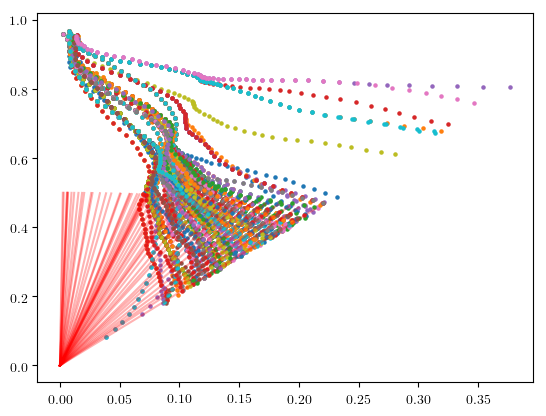

In [18]:
overlay(unfold_render, unfold_pf_traces, same_data=true)

We now empirically investigate the scaling behavior of (1) the inference program that uses the Julia `for` loop,  and (2) the equivalent inference program that uses Unfold. We will use a fake long vector of z data, and we will investigate how the running time depends on the number of observations.

In [ ]:
fake_zs = rand(1000);

function timing_experiment(num_observations_list::Vector{Int}, num_particles::Int, num_samples::Int)
    times = Vector{Float64}()
    times_unfold = Vector{Float64}()
    for num_observations in num_observations_list
        println("evaluating inference programs for num_observations: $num_observations")
        tstart = time_ns()
        traces = particle_filter(num_particles, fake_zs[1:num_observations], num_samples)
        push!(times, (time_ns() - tstart) / 1e9)
        
        tstart = time_ns()
        traces = unfold_particle_filter(num_particles, fake_zs[1:num_observations], num_samples)
        push!(times_unfold, (time_ns() - tstart) / 1e9)
        
    end
    (times, times_unfold)
end;

num_observations_list = [1, 3, 10, 30, 50, 100, 150, 200, 500]
(times, times_unfold) = timing_experiment(num_observations_list, 100, 20);

Notice that the running time of the inference program without unfold appears to be quadratic in the number of observations, whereas the inference program that uses unfold appears to scale linearly:

In [ ]:
plot(num_observations_list, times, color="blue")
plot(num_observations_list, times_unfold, color="red")
xlabel("Number of observations")
ylabel("Running time (sec.)");

## 5. Using a custom proposal

The particle filtering implementations above used the default proposal to extend the state at each time step. We can improve the performance of the particle filter by using a custom proposal instead, that takes into account the latest data observation.

at a given time step, we have

    vx = @trace(normal(prev_state.vx, sqrt(velocity_var)), :vx)
    vy = @trace(normal(prev_state.vy, sqrt(velocity_var)), :vy)
    x = prev_state.x + vx
    y = prev_state.y + vy
    @trace(normal(atan(x, y), measurement_noise), :z)
    
so, the previous state is prev_state.vx, prev_state.vy, and prev_state.x, and prev_state.y
the new randomness to be proposed is vx and vy
given a new bearing measuremeent, with measurement_noise, what is a good proposal

q(new_vx, new_vy; vx, vy, x, y, atan(x, y))

Can we train it using amortized inference, on simulated data?

independent proposal? or dependent?

independent proposal q(new_vx; vx, vy, x, y, new bearing)

p(new_vx, new_vy | x, y, vx, vy, normal(4atan(x, y), ..) == obs)

In [ ]:
function compute_proposal_dist(vx, vy, velocity_var, measurement_noise, observed_bearing, tau)
    
    # the optimum value for tau is related to the measurement noise
    
    # X
    mu = [vx, vy, 0.0]
    cov = [velocity_var  0.0            0.0;
           0.0           velocity_var   0.0;
           0.0           0.0            tau]
    
    # Y = c + B * X
    c = [0.0, 0.0, 0.0]
    B = [1.0                    0.0    0.0;
         0.0                    1.0    0.0;
         tan(observed_bearing)  1.0    1.0]
    new_cov = B * cov * B'
    new_mu = c + B * mu
    
    # now, condition on the event that Y[3] == 0.0
    cov11 = new_cov[1:2,1:2]
    cov12 = new_cov[1:2,3:3]
    cov21 = new_cov[3:3,1:2]
    cov22 = new_cov[3:3,3:3]
    mu1 = new_mu[1:2]
    mu2 = new_mu[3:3]
    cond_mu = mu1 + cov12 * inv(cov22) * ([0.0] - mu2)
    cond_cov = cov11 - cov12 * inv(cov22) * cov21
    
    (conv_mu, conv_cov)
end

In [248]:
@gen function custom_proposal(trace, t::Int)
    
    @param ax::Vector{Float64}
    @param bx::Vector{Float64}
    @param ay::Vector{Float64}
    @param by::Vector{Float64}
    
    @assert t > 0
        
    (init_state, states) = get_retval(trace)

    if t > 1
        x = states[t-1].x
        y = states[t-1].y
        vx = states[t-1].vx
        vy = states[t-1].vy
    else
        x = init_state.x
        y = init_state.y
        vx = init_state.vx
        vy = init_state.vy
    end

    velocity_var = (1.0/1e6)
    observed_bearing = trace[:chain => t => :z]
    current_r = sqrt(x * x + y * y)
    observed_
    current_bearing = atan(x, y)
    input = [current_bearing, 0., 0., observed_bearing]
    vx_mu_adjust = ax' * input
    vx_std_adjust = exp(bx' * input)
    vy_mu_adjust = ay' * input
    vy_std_adjust = exp(by' * input)
    vx = @trace(normal(vx + vx_mu_adjust, sqrt(velocity_var) * vx_std_adjust), :chain => t => :vx)
    vy = @trace(normal(vy + vy_mu_adjust, sqrt(velocity_var) * vy_std_adjust), :chain => t => :vy)
    
    (vx, vy, vx_std_adjust, vy_std_adjust)
end;

In [249]:
init_param!(custom_proposal, :ax, zeros(5))
init_param!(custom_proposal, :bx, zeros(5))
init_param!(custom_proposal, :ay, zeros(5))
init_param!(custom_proposal, :by, zeros(5))

5-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [250]:
trace = simulate(unfold_model, (100,));

In [251]:
vx, vy, vx_std_adjust, vy_std_adjust = custom_proposal(trace, 2)

(0.001314751948038535, -0.005755651973101921, 1.0, 1.0)

In [252]:
T = 100
training_traces = []
for i=1:1000
    push!(training_traces, simulate(unfold_model, (T,)))
end

### Train a mixture model on the simulated data.
Mixture over 7 variables:
(1) x, y, vx, vy, t, vx_new, vy_new



In [253]:
using Random: randperm

function estimate_objective(n)
    objective = 0.
    permuted = randperm(length(training_traces))
    for (i, model_tr) in enumerate(training_traces[permuted][1:n])
        for t=1:T-1
            constraints = choicemap()
            constraints[:chain => t => :vx] = model_tr[:chain => t => :vx]
            constraints[:chain => t => :vy] = model_tr[:chain => t => :vy]
            prop_tr, w = generate(custom_proposal, (model_tr, t), constraints)
            objective += w
        end
    end
    objective / ((T-1) * n)
end

estimate_objective (generic function with 2 methods)

In [254]:
conf = FixedStepGradientDescent(1e-7)
opt_update = ParamUpdate(conf, (custom_proposal, [:ax, :bx, :ay, :by]))
n = 1000

init_param!(custom_proposal, :ax, zeros(5))
init_param!(custom_proposal, :bx, zeros(5))
init_param!(custom_proposal, :ay, zeros(5))
init_param!(custom_proposal, :by, zeros(5))

for iter=1:250
    
    # accumulate the gradients and objective function
    objective = 0.
    permuted = randperm(length(training_traces))
    for (i, model_tr) in enumerate(training_traces[permuted][1:n])
        for t=1:T-1
            constraints = choicemap()
            constraints[:chain => t => :vx] = model_tr[:chain => t => :vx]
            constraints[:chain => t => :vy] = model_tr[:chain => t => :vy]
            prop_tr, w = generate(custom_proposal, (model_tr, t), constraints)
            objective += w
            accumulate_param_gradients!(prop_tr, nothing, 1.0 / (n * (T-1)))
        end
    end

    apply!(opt_update)
    
    objective_scaled = objective / (n * (T-1))
    println("iter: $iter, objective scaled: $objective_scaled")
end

iter: 1, objective scaled: 10.98093638133762
iter: 2, objective scaled: 10.980955216003506
iter: 3, objective scaled: 10.980964513752836


InterruptException: InterruptException:

In [246]:
ax = get_param(custom_proposal, :ax)
ay = get_param(custom_proposal, :ay)
bx = get_param(custom_proposal, :bx)
by = get_param(custom_proposal, :by)

5-element Array{Float64,1}:
  2.0765783261114455e-8 
  2.2972154029801513e-8 
  2.8177357452609313e-10
 -2.6947149386477277e-10
  6.37806588701251e-8   

In [247]:
println(ax)
println(ay)
println(bx)
println(by)

[3.84303e-6, 6.5463e-6, 2.60179e-8, -3.82189e-7, -2.09623e-6]
[2.42946e-6, 1.90288e-6, -4.44423e-8, 2.88504e-7, 2.51036e-6]
[-1.86265e-9, 2.20191e-8, -3.308e-11, -3.52593e-10, 6.73754e-8]
[2.07658e-8, 2.29722e-8, 2.81774e-10, -2.69471e-10, 6.37807e-8]


In [116]:
set_param!(custom_proposal, :ax, ax)
set_param!(custom_proposal, :ay, ay)
set_param!(custom_proposal, :bx, bx)
set_param!(custom_proposal, :by, by)

5-element Array{Float64,1}:
  -5.788656819291693  
 -12.759713240972921  
  -0.10672199597928947
   0.6862024863498911 
 -32.07825392356726   

In [117]:
function unfold_particle_filter_custom_proposal(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    init_obs = Gen.choicemap((:z0, zs[1]))    
    state = Gen.initialize_particle_filter(unfold_model, (0,), init_obs, num_particles)
    for t=1:length(zs)-1

        maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap((:chain => t => :z, zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs, custom_proposal, (t,))
    end
    
    # return a sample of traces from the weighted collection:
    return Gen.sample_unweighted_traces(state, num_samples)
end;

In [118]:
@time unfold_pf_custom_proposal_traces = unfold_particle_filter_custom_proposal(5000, zs, 200);

ErrorException: BoundsError(#undef, #undef) :: Index 1 out of bounds (0)

We will approximate the likelihood by a straight line with constant width. Taking the product of that likelihood and the prior should result in another multivariate Gaussian. This is an approximation because the noise in the bearing measurement is an angular noise, which corresponds to more or less distance noise depending on how far the object is.

We will use a noise that is conservative. If the angular measurement noise is $\sigma_{\theta}$ (in radians), then we will set a single standard deviation of a band along the bearing ray to:
$$
\tau = 2 \cdot \sigma_{\theta} \cdot\max\{||[x, y]||_2, ||[x + v_x, y + v_y]||_2\}
$$

If we scale up this more, our proposal approaches the default dynamics-only proposal. But it becomes less informative. The factor of 2 is already conservative. (I wonder if this is an instance of a more general family of models where we linearize a nonlinear observation model, then conservatively scale up the variance.)

Given a previous state of $(x, y, v_x, v_y)$, with velocity variance $\sigma^2$, the prior (i.e. dynamics) distribution on the new velocity $v_x', v_y'$ is:
$$
[v_x', v_y'] \sim \mathcal{N}([x + v_x, y + v_y], \sigma^2 \cdot I_2)
$$

Our approximate likelihood is defined by the following 'factor' function:
$$
\phi_{\theta,\tau,x,y}(v_x', v_y') = \exp{\left(-\frac{(d_{\theta}(x + \Delta T v_x', y + \Delta T v_y'))^2}{2 \tau}\right)}
$$
where $d_{\theta}$ gives the perpendicular distance from the line through the origin with angle $\theta$ from the x-axis (the line corresponding to the bearing measurement).

We want to show that the distribution on $(v_x', v_y')$ that is proportional to the product of the prior on $v_x', v_y'$ with this factor is a bivariate Gaussian.

First, let $\mathbf{u}_{\theta} := [\cos \theta, \sin \theta]$ (which is a unit vector). Then the distance from a point $x, y$ to the $\theta$ line is:
$$
d_{\theta}(x, y) = ||[x, y] - (\mathbf{u}_{\theta} \cdot [x, y]) \mathbf{u}_{\theta}||_2
$$
Expanding:
$$
\begin{align}
(d_{\theta}(x, y))^2
&= (x - (u_1 x + u_2 y) u_1)^2 + (y - (u_1 x + u_2 y) u_2)^2\\
&= (x ( 1 - u_1^2) - y u_1 u_2)^2 + (y ( 1 - u_2^2) - x u_1 u_2)^2
\end{align}
$$
Letting $A := 1 - u_1^2$ and $B := 1 - u_2^2$ and $C := u_1 u_2$:
$$
\begin{align}
(d_{\theta}(x, y))^2
&= (x A - y C)^2 + (y B - x C)^2\\
&= x^2 A^2 - 2 A C x y + y^2 C^2 + y^2 B^2 - 2 B C x y + C^2 x^2\\
&= x^2 (A^2 + C^2) + y^2 (B^2 + C^2) + xy (-2 A C - 2 B C)
\end{align}
$$
Let $D := A^2 + C^2$ and $E := B^2 + C^2$ and $F := -2 A C - 2 B C$:
$$
\begin{align}
(d_{\theta}(x, y))^2
&= D x^2 + E y^2 + F xy
\end{align}
$$
Now, substituting $x := x_0 + v_x' \Delta$ and $y := y_0 + v_y' \Delta$:
$$
\begin{align}
(d_{\theta,x_0,y_0}(v_x', v_y'))^2
&= D (x_0 + v_x' \Delta)^2 + E (y_0 + v_y' \Delta)^2 + F (x_0 + v_x' \Delta) (y_0 + v_y' \Delta)
\end{align}
$$
Therefore (INTERMEDIATE RESULT):
$$
\phi_{\theta,\tau,x,y}(v_x', v_y') =
\exp{\left(-\frac{D (x + v_x' \Delta)^2 + E (y + v_y' \Delta)^2 + F (x + v_x' \Delta) (y + v_y' \Delta)}{2 \tau}\right)}
$$




----
Old:

Since the new x coordinate is $x + v_x' \Delta T$ and similarly for $y$, we have:
$$
\phi_{\theta,\tau,x,y}(v_x', v_y') = \exp{\left(-\frac{||[x + v_x' \Delta T, y + v_y' \Delta T] - (\mathbf{u}_{\theta} \cdot [x + v_x' \Delta T, y + v_y' \Delta T]) \mathbf{u}_{\theta}||_2^2}{2 \tau}\right)}
$$
Let $u_1 := \mathbf{u}_{\theta,1}$ and $u_2 := \mathbf{u}_{\theta,2}$. Then:
$$
\begin{align}
\phi_{\theta,\tau,x,y}(v_x', v_y') &=
\exp{\left(-\frac{||[x + v_x' \Delta T, y + v_y' \Delta T] - ((x + v_x' \Delta) u_1 + (y + v_y' \Delta) u_2) [u_1, u_2]||_2^2}{2 \tau}\right)}\\
&= \exp{\left(-\frac{
(x + v_x' \Delta - ((x + v_x' \Delta) u_1 + (y + v_y' \Delta) u_2) u_1)^2
+ 
(y + v_y' \Delta - ((x + v_x' \Delta) u_1 + (y + v_y' \Delta) u_2) u_2)^2
}{2 \tau}\right)}
\end{align}
$$
We now simplify the term in the numerator inside the exponential:
$$
\begin{align}
\phi_{\theta,\tau,x,y}(v_x', v_y') := \exp\left(-\frac{f_{\theta,tau,x,y}(v_x', v_y')}{2 \tau}\right)
\end{align}
$$
where
$$
\begin{align}
f_{\theta,\tau,x,y}(v_x', v_y') &=
\end{align}
$$